In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob, inspect, sys
import re

from sklearn.preprocessing import MinMaxScaler

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [2]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
df =  pd.read_csv("../../Data/Merged_data/CopulaGAN_simulated_data.csv", index_col=0)
df.drop(columns=["type_cw"], inplace=True)


In [4]:
# df = df[df['Type']=='347']
df['log_PC_IF_2.25MHz'] = np.log(df['PC_IF_2.25MHz']+1)
df['log_beta_avg'] = np.log(df['Beta_avg'])
df.drop(columns=['PC_IF_2.25MHz', 'Beta_avg'], inplace=True)


In [5]:
scaling_cols = [ 'MS_Avg', 'TEP_average', 'PC_IF_3.5MHz', 'PC_BS', 'log_PC_IF_2.25MHz', 'log_beta_avg','KJIC']

scaled_df = df.copy()
scaled_df["KJIC"] = np.log(scaled_df.index)
scaled_df[scaling_cols] = mc.scale_general(scaled_df[scaling_cols], MinMaxScaler())[0]
scaled_df = scaled_df[scaling_cols + ["Type"]]


## SVR

In [31]:
ss304 = scaled_df[scaled_df['Type']=='304']
ss316 = scaled_df[scaled_df['Type']=='316']
ss347 = scaled_df[scaled_df['Type']=='347']


def svr_pipeline(mat_df):
    mat_df = mat_df.drop(columns=["Type"])
    
    X_train, X_test, y_train, y_test = train_test_split(mat_df.drop(columns=['KJIC']), 
                                                                mat_df['KJIC'], 
                                                                test_size=0.2, 
                                                                random_state=2020)
    svr = SVR()
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    
    
    print("r2 score for training: ", r2_score(y_train, svr.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, y_pred))
    
    
    plt.scatter(y_test, y_pred)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return 


r2 score for training:  0.8096572042560545
r2 score for testing:  0.8175181663743859


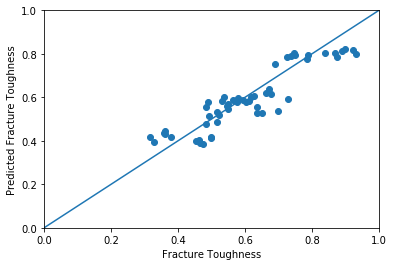

In [32]:
svr_pipeline(ss304)

r2 score for training:  0.7282546231252183
r2 score for testing:  0.5584441466827984


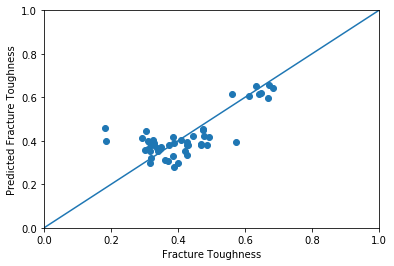

In [33]:
svr_pipeline(ss316)

r2 score for training:  0.9151792058295052
r2 score for testing:  0.8704930985335444


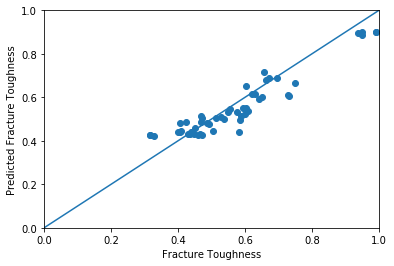

In [34]:
svr_pipeline(ss347)

## Random Forest Regressor

In [35]:
def rf_pipeline(mat_df):
    mat_df = mat_df.drop(columns=["Type"])
    
    X_train, X_test, y_train, y_test = train_test_split(mat_df.drop(columns=['KJIC']), 
                                                                mat_df['KJIC'], 
                                                                test_size=0.2, 
                                                                random_state=2020)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    print("r2 score for training: ", r2_score(y_train, model.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, y_pred))
    
    
    plt.scatter(y_test, y_pred)
    plt.plot([0, 1], [0, 1])
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return 

r2 score for training:  0.9698392197953551
r2 score for testing:  0.8204252558385008


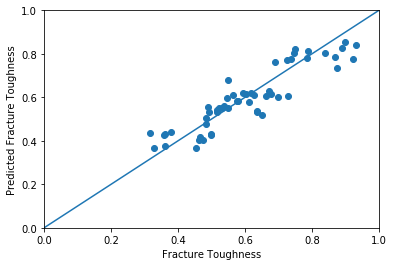

In [36]:
rf_pipeline(ss304)

r2 score for training:  0.9525017980194103
r2 score for testing:  0.5923733535760287


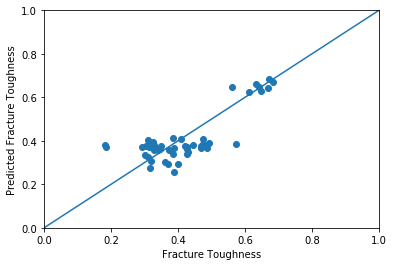

In [37]:
rf_pipeline(ss316)

r2 score for training:  0.9883245875141945
r2 score for testing:  0.8907738072410575


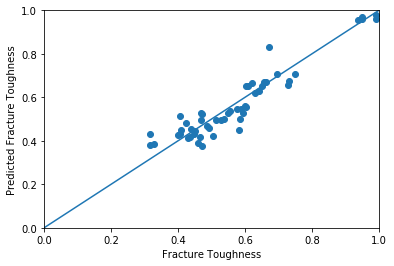

In [38]:
rf_pipeline(ss347)